In [77]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from prophet import Prophet

In [78]:
# Load the data from a CSV file
df = pd.read_csv("../data/pollofpolls.csv", sep=";")

In [79]:
#df

In [80]:
# Ensure the "Mnd" column is treated as a string (optional but recommended)
df["Mnd"] = df["Mnd"].astype(str)

# Create an empty dictionary for the predictions
predictions = {"Mnd": ["Februar-25", "Mars-25","April-25","Mai-25","Juni-25","Juli-25","August-25","September-25"]}


In [81]:
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

#print(df)  # Check that dates are correctly formatted at month-end


In [82]:
# Loop through each column in the DataFrame and apply Prophet separately
future_predictions = {}

for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    df_prophet = df[[party]].reset_index()
    df_prophet.columns = ["ds", "y"]  # Prophet requires 'ds' (date) and 'y' (value)
    
    model = Prophet(interval_width=0.95)
    model.fit(df_prophet)
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=8, freq='ME')  # 8 month-end predictions
    forecast = model.predict(future)
    
    future_predictions[party] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

16:34:59 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:02 - cmdstanpy - INFO - Chain [1] start processing
16:35:02 - cmdstanpy - INFO - Chain [1] done processing
16:35:02 - cmdstanpy - INFO - Chain [1] start processing
16:35:02 - cmdstanpy - INFO - Chain [1] done processing
16:35:03 - cmdstanpy - INFO - Chain [1] start processing
16:35:03 - cmdstanpy - INFO - Chain [1] done processing
16:35:03 - cmdstanpy - INFO - Chain [1] start processing
16:35:03 - cmdstanpy - INFO - Chain [1]

In [83]:
future_predictions

{'Ap':            ds       yhat  yhat_lower  yhat_upper
 0  2021-01-31  25.951865   24.207327   27.809285
 1  2021-02-28  25.476336   23.735145   27.186057
 2  2021-03-31  24.716843   22.985007   26.637928
 3  2021-04-30  25.080721   23.395796   26.822092
 4  2021-05-31  25.023360   23.238696   26.812705
 5  2021-06-30  24.655317   22.864059   26.434168
 6  2021-07-31  25.054725   23.224559   26.664373
 7  2021-08-31  24.381551   22.567410   26.166491
 8  2021-09-30  24.335463   22.629640   26.010914
 9  2021-10-31  24.601902   22.941988   26.588405
 10 2021-11-30  23.470351   21.686090   25.162506
 11 2021-12-31  21.741257   19.942191   23.466909
 12 2022-01-31  22.533617   20.707453   24.304154
 13 2022-02-28  21.849928   20.035326   23.709190
 14 2022-03-31  21.199004   19.386535   22.924876
 15 2022-04-30  21.790419   20.059386   23.558942
 16 2022-05-31  21.746549   19.893985   23.424874
 17 2022-06-30  21.324104   19.446012   23.206831
 18 2022-07-31  21.671922   19.947769   23.5

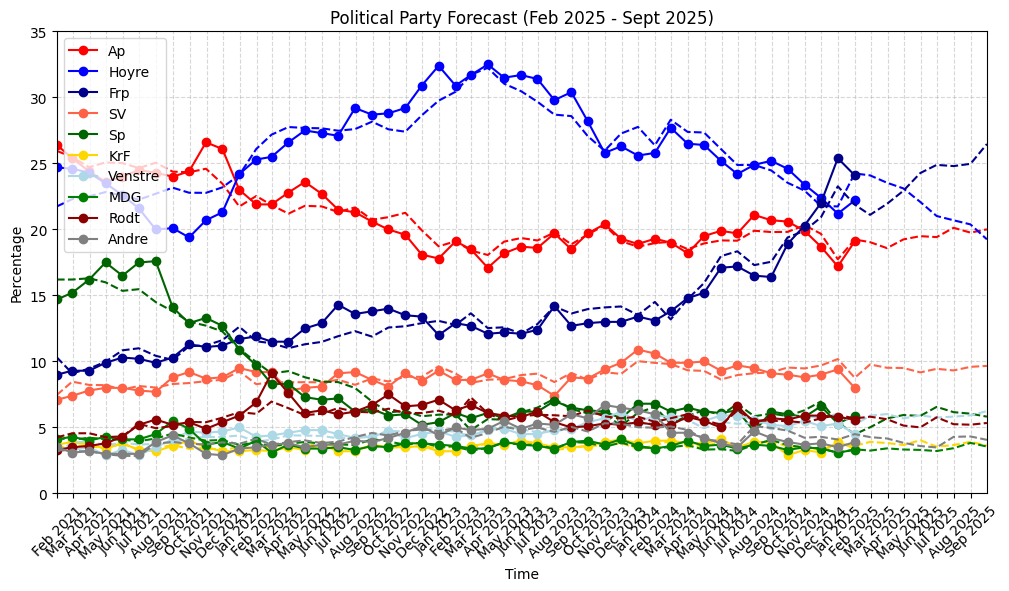

In [84]:

plt.figure(figsize=(12, 6))

# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rodt', 'Andre']:
    color = colors.get(party, np.random.rand(3,))  # Use predefined color or random if missing
    
    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")
    
    # Check if forecast exists for this party
    if party in future_predictions:
        forecast_df = future_predictions[party]  # Get forecast dataframe for this party
        
        # Plot Prophet's forecast (dashed line)
        plt.plot(forecast_df['ds'], forecast_df['yhat'], linestyle="dashed", color=color)

# Set x-axis limits: Min from original data, max to Sept 2025
plt.xlim(df.index.min(), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025

# Set x-axis ticks for only months where we have data
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Auto-detect month positions
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Format as "Jan 2025"

# Format y-axis for every whole percentage
plt.yticks(np.arange(0, 40, 5))  # Assuming percentages from 0 to 100

# Add grid lines
plt.grid(True, linestyle="--", alpha=0.5)  # Light dashed grid

plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Political Party Forecast (Feb 2025 - Sept 2025)")

# Move legend to the upper left
plt.legend(loc="upper left")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


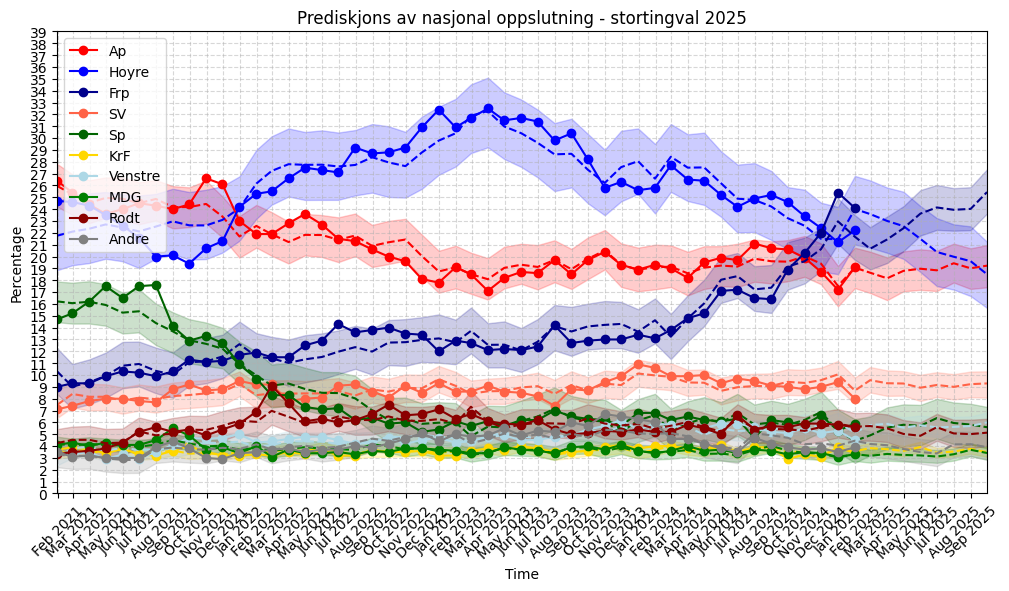

In [85]:
plt.figure(figsize=(12, 6))

# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

# Collect all forecasts in a new dataframe for normalization
scaled_forecasts = {}

# Normalize the predictions at each time step
all_dates = future_predictions['Ap']['ds']  # Assume all parties share the same time steps
total_sums = np.zeros(len(all_dates))  # Initialize sum array

# Step 1: Compute total sum per time step
for party in future_predictions.keys():
    total_sums += future_predictions[party]['yhat'].values

# Step 2: Normalize each party's forecast
for party in future_predictions.keys():
    forecast_df = future_predictions[party].copy()
    forecast_df['yhat'] = (forecast_df['yhat'] / total_sums) * 100  # Normalize to sum 100%
    forecast_df['yhat_lower'] = (forecast_df['yhat_lower'] / total_sums) * 100
    forecast_df['yhat_upper'] = (forecast_df['yhat_upper'] / total_sums) * 100
    scaled_forecasts[party] = forecast_df  # Store scaled results

# Plot actual and scaled forecasts
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rodt', 'Andre']:
    color = colors.get(party, np.random.rand(3,))  # Use predefined color or random if missing
    
    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")
    
    # Check if forecast exists for this party
    if party in scaled_forecasts:
        forecast_df = scaled_forecasts[party]  # Get scaled forecast dataframe
        
        # Plot Prophet's forecast (dashed line)
        plt.plot(forecast_df['ds'], forecast_df['yhat'], linestyle="dashed", color=color)

        # Plot confidence interval as a shaded region
        plt.fill_between(
            forecast_df['ds'], 
            forecast_df['yhat_lower'], 
            forecast_df['yhat_upper'], 
            color=color, 
            alpha=0.2  # Transparency level
        )

# Set x-axis limits: Min from original data, max to Sept 2025
plt.xlim(df.index.min(), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025

# Set x-axis ticks for only months where we have data
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Auto-detect month positions
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Format as "Jan 2025"

# Format y-axis for every whole percentage
plt.yticks(np.arange(0, 40, 1))  # Assuming percentages from 0 to 100

# Add grid lines
plt.grid(True, linestyle="--", alpha=0.5)  # Light dashed grid

plt.xlabel("Time")
plt.ylabel("Percentage")
plt.title("Prediskjons av nasjonal oppslutning - stortingval 2025")

# Move legend to the upper left
plt.legend(loc="upper left")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()


In [86]:
parties=['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rodt', 'Andre']

In [87]:
results = []

In [88]:
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG', 'Rodt', 'Andre']:
    forecast_df = scaled_forecasts[party]
    res=scaled_forecasts[party][scaled_forecasts[party]["ds"] == '2025-09-30']
    for _, row in res.iterrows():
        results.append({
            "party": party,
            "estimate": row["yhat"],
            "lower": row["yhat_lower"],
            "high": row["yhat_upper"]
        })

In [89]:
all_pred = pd.DataFrame(results)

In [90]:
all_pred

,party,estimate,lower,high
0,Ap,19.232083,17.403175,20.973558
1,Hoyre,18.504629,15.660473,21.245416
2,Frp,25.443152,23.630302,27.368616
3,SV,9.289484,8.087047,10.310349
4,Sp,5.593741,3.795392,7.308616
5,KrF,3.486558,3.095527,3.928326
6,Venstre,5.996908,5.218467,6.835968
7,MDG,3.416563,2.852166,3.949766
8,Rodt,5.132772,4.021895,6.305181
9,Andre,3.904109,2.846611,4.983875


In [91]:
scaled_forecasts["Ap"][scaled_forecasts["Ap"]["ds"] == '2025-09-30']

,ds,yhat,yhat_lower,yhat_upper
56,2025-09-30,19.232083,17.403175,20.973558
